In [1]:
!nvidia-smi

Thu Jul 19 16:12:38 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    30W / 149W |      0MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# On Deep Learning-Based Channel Decoding

If you want to cite this notebook, please use the following bibtext entry:

    @article{nn-decoding,
      title={On Deep Learning-Based Channel Decoding},
      author={Tobias Gruber and
              Sebastian Cammerer and
              Jakob Hoydis and
              Stephan ten Brink}
      journal={CoRR}
      year={2017}
      url= {http://arxiv.org/abs/1701.07738}
    }

Running this example requires Keras installed with the Tensorflow backend. For GPU support nvidia-docker is required. A Dockerfile is provided to employ this setup quickly.

Our simulation setup was inspired by material from http://radioml.org.


In [2]:
# Setting environment variable so that only GPU0 is visible
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
import keras.backend.tensorflow_backend as KTF

def get_session(gpu_fraction=0.1):
    
    num_threads = os.environ.get('OMP_NUM_THREADS')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)

    if num_threads:
        return tf.Session(config=tf.ConfigProto(
            gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
    else:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

KTF.set_session(get_session())

Using TensorFlow backend.


In [0]:
import keras
import numpy as np
from keras.models import Sequential
from keras.models import Sequential, Model
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D, Flatten, Reshape, Concatenate, Add
from keras.layers.core import Dense, Lambda
from keras.layers import Input
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

# Parameters

In [0]:
k = 20                      # number of information bits
N = 32                      # code length
train_SNR_Eb = 3            # training-Eb/No

nb_epoch = 1200           # number of learning epochs, why so huge?
code = 'polar'              # type of code ('random' or 'polar'),
design = [128, 64, 32]      # each list entry defines the number of nodes in a layer
batch_size = 256            # size of batches for calculation the gradient
LLR = False                 # 'True' enables the log-likelihood-ratio layer
optimizer='Adam'
loss = 'binary_crossentropy'                # or 'mse'

train_SNR_Es = train_SNR_Eb + 10*np.log10(k/N)
train_sigma = np.sqrt(1/(2*10**(train_SNR_Es/10)))

# Define helper functions

In [0]:
def modulateBPSK(x):
    return -2*x +1;

def addNoise(x, sigma):
    w = K.random_normal(K.shape(x), mean=0.0, stddev=sigma)
    return x + w

def ber(y_true, y_pred):
    return K.mean(tf.cast(K.not_equal(y_true, K.round(y_pred)),tf.float32))

def return_output_shape(input_shape):  
    return input_shape

def compose_model(layers):
    model = Sequential()
    for layer in layers:
        model.add(layer)
    return model

def log_likelihood_ratio(x, sigma):
    return 2*x/np.float32(sigma**2)

def errors(y_true, y_pred):
    return tf.reduce_sum(tf.cast(tf.not_equal(y_true, K.round(y_pred)),tf.float32))

# Define the neural Network

This block describes the neur

In [0]:
#--------------functional API---------
input_layer=Input(shape=(N,))

m1 = Lambda(modulateBPSK, output_shape=return_output_shape, name="modulator")(input_layer)

n1=Lambda(addNoise, arguments={'sigma':train_sigma},output_shape=return_output_shape, name="noise")(m1)

#--------------ResNet decoder--------
#define conv net
Nstages=2 #5
incept_dim=[8, 8, 8, 8, 8, 8, 8]
incept_size=[2, 4, 8, 16, 32, 64, 32]

ch_out=Reshape((N,1))(n1)
dec_in=Input(shape=(N,))
lt_out=Reshape((N,1))(dec_in)

for i in range(0,Nstages):  
    #inception block
    if i == 0:
        branch1 = Conv1D(filters=incept_dim[0], kernel_size=incept_size[0], activation='relu', padding='same')(lt_out)
        branch2 = Conv1D(filters=incept_dim[1], kernel_size=incept_size[1], activation='relu', padding='same')(lt_out)       
    if i == 1:
        branch1 = Conv1D(filters=incept_dim[2], kernel_size=incept_size[2], activation='relu', padding='same')(lt_out)
        branch2 = Conv1D(filters=incept_dim[3], kernel_size=incept_size[3], activation='relu', padding='same')(lt_out)       
    if i == 2:
        branch1 = Conv1D(filters=incept_dim[2], kernel_size=incept_size[2], activation='relu', padding='same')(lt_out)
        branch2 = Conv1D(filters=incept_dim[4], kernel_size=incept_size[3], activation='relu', padding='same')(lt_out)        
    if i == 3:
        branch1 = Conv1D(filters=incept_dim[2], kernel_size=incept_size[2], activation='relu', padding='same')(lt_out)
        branch2 = Conv1D(filters=incept_dim[3], kernel_size=incept_size[3], activation='relu', padding='same')(lt_out)
        
    lt=Concatenate()([branch1, branch2])
    
    lt_short=lt_out
   
    lt_out=Add()([lt, lt_short])  

lt_out=Flatten()(lt_out)
l_out_pre1 = Dense(80,activation='relu')(lt_out)
l_out_pre2 = Dense(60,activation='relu')(l_out_pre1)
l_out_pre3 = Dense(35,activation='relu')(l_out_pre2)
l_out=Dense(k,activation='sigmoid')(l_out_pre3)

#l_out=Reshape((N,))(l_out)
#l_out2=Reshape((N,))(l_out2)

# Define model

decoder_nn = Model(inputs=dec_in, outputs=[l_out])
decoder_nn.compile(optimizer=optimizer, loss=loss, metrics=[errors,ber])


l_out_t=decoder_nn(ch_out)
#model_resnet = Model(inputs=input_layer, outputs=[l_out, l_out2])
model_resnet = Model(inputs=input_layer, outputs=[l_out_t])

#model.compile(optimizer=optimizer, loss=loss, metrics=[ber])
#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_resnet.compile(optimizer=optimizer, loss=loss, loss_weights=[1], metrics=[errors,ber])

#model_resnet.summary()

#define a shorter model for init learning
#model_resnet_short = Model(inputs=input_layer, outputs=[l_out2])
#model_resnet_short.compile(optimizer=optimizer, loss=loss, metrics=[ber])

In [7]:
model_resnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
modulator (Lambda)           (None, 32)                0         
_________________________________________________________________
noise (Lambda)               (None, 32)                0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 1)             0         
_________________________________________________________________
model_1 (Model)              (None, 20)                51907     
Total params: 51,907
Trainable params: 51,907
Non-trainable params: 0
_________________________________________________________________


# Data Generation

The following block describes polar encoding. This is beyond the scope of this lecture (but necessary for data generation). For further details we refer to the "Error Control Coding lecture".

In [0]:
def half_adder(a,b):
    s = a ^ b
    c = a & b
    return s,c

def full_adder(a,b,c):
    s = (a ^ b) ^ c
    c = (a & b) | (c & (a ^ b))
    return s,c

def add_bool(a,b):
    if len(a) != len(b):
        raise ValueError('arrays with different length')
    k = len(a)
    s = np.zeros(k,dtype=bool)
    c = False
    for i in reversed(range(0,k)):
        s[i], c = full_adder(a[i],b[i],c)    
    if c:
        warnings.warn("Addition overflow!")
    return s

def inc_bool(a):
    k = len(a)
    increment = np.hstack((np.zeros(k-1,dtype=bool), np.ones(1,dtype=bool)))
    a = add_bool(a,increment)
    return a

def bitrevorder(x):
    m = np.amax(x)
    n = np.ceil(np.log2(m)).astype(int)
    for i in range(0,len(x)):
        x[i] = int('{:0{n}b}'.format(x[i],n=n)[::-1],2)  
    return x

def int2bin(x,N):
    if isinstance(x, list) or isinstance(x, np.ndarray):
        binary = np.zeros((len(x),N),dtype='bool')
        for i in range(0,len(x)):
            binary[i] = np.array([int(j) for j in bin(x[i])[2:].zfill(N)])
    else:
        binary = np.array([int(j) for j in bin(x)[2:].zfill(N)],dtype=bool)
    
    return binary

def bin2int(b):
    if isinstance(b[0], list):
        integer = np.zeros((len(b),),dtype=int)
        for i in range(0,len(b)):
            out = 0
            for bit in b[i]:
                out = (out << 1) | bit
            integer[i] = out
    elif isinstance(b, np.ndarray):
        if len(b.shape) == 1:
            out = 0
            for bit in b:
                out = (out << 1) | bit
            integer = out     
        else:
            integer = np.zeros((b.shape[0],),dtype=int)
            for i in range(0,b.shape[0]):
                out = 0
                for bit in b[i]:
                    out = (out << 1) | bit
                integer[i] = out
        
    return integer

def polar_design_awgn(N, k, design_snr_dB):  
        
    S = 10**(design_snr_dB/10)
    z0 = np.zeros(N)

    z0[0] = np.exp(-S)
    for j in range(1,int(np.log2(N))+1):
        u = 2**j
        for t in range(0,int(u/2)):
            T = z0[t]
            z0[t] = 2*T - T**2     # upper channel
            z0[int(u/2)+t] = T**2  # lower channel
        
    # sort into increasing order
    idx = np.argsort(z0)
        
    # select k best channels
    idx = np.sort(bitrevorder(idx[0:k]))
    
    A = np.zeros(N, dtype=bool)
    A[idx] = True
        
    return A

def polar_transform_iter(u):

    N = len(u)
    n = 1
    x = np.copy(u)
    stages = np.log2(N).astype(int)
    for s in range(0,stages):
        i = 0
        while i < N:
            for j in range(0,n):
                idx = i+j
                x[idx] = x[idx] ^ x[idx+n]
            i=i+2*n
        n=2*n
    return x

In [0]:
# Create all possible information words
d = np.zeros((2**k,k),dtype=bool)
for i in range(1,2**k):
    d[i]= inc_bool(d[i-1])

# Create sets of all possible codewords (codebook)
if code == 'polar':   
    
    A = polar_design_awgn(N, k, design_snr_dB=0)  # logical vector indicating the nonfrozen bit locations 
    x = np.zeros((2**k, N),dtype=bool)
    u = np.zeros((2**k, N),dtype=bool)
    u[:,A] = d
    for i in range(0,2**k):
        x[i] = polar_transform_iter(u[i])

elif code == 'random':
    
    np.random.seed(4267)   # for a 16bit Random Code (r=0.5) with Hamming distance >= 2
    x = np.random.randint(0,2,size=(2**k,N), dtype=bool)

# Train Neural Network

In [0]:
# history = model_resnet_short.fit(x, [d], batch_size=batch_size, epochs=nb_epoch, verbose=2, shuffle=True)

In [0]:
##history = model_resnet.fit(x, [d, d], batch_size=batch_size, epochs=nb_epoch, verbose=2, shuffle=True)

In [12]:
model_resnet.summary()
#history = model.fit(x, d, batch_size=batch_size, nb_epoch=nb_epoch, verbose=0, shuffle=True)
history = model_resnet.fit(x, d, batch_size=batch_size, epochs=nb_epoch, verbose=2, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
modulator (Lambda)           (None, 32)                0         
_________________________________________________________________
noise (Lambda)               (None, 32)                0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 1)             0         
_________________________________________________________________
model_1 (Model)              (None, 20)                51907     
Total params: 51,907
Trainable params: 51,907
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1200
 - 110s - loss: 0.5413 - errors: 1772.2759 - ber: 0.3461
Epoch 2/1200
 - 110s - loss: 0.4951 - errors: 1565.9741 - ber: 0.305

KeyboardInterrupt: ignored

# Evaluate NN - Simulate BER Curves

In [0]:
test_batch = 1000  
num_words = 10000      # multiple of test_batch

SNR_dB_start_Eb = 0
SNR_dB_stop_Eb = 5
SNR_points = 20


In [0]:
SNR_dB_start_Es = SNR_dB_start_Eb + 10*np.log10(k/N)
SNR_dB_stop_Es = SNR_dB_stop_Eb + 10*np.log10(k/N)

sigma_start = np.sqrt(1/(2*10**(SNR_dB_start_Es/10)))
sigma_stop = np.sqrt(1/(2*10**(SNR_dB_stop_Es/10)))

sigmas = np.linspace(sigma_start, sigma_stop, SNR_points)

nb_errors = np.zeros(len(sigmas),dtype=float)
nb_bits = np.zeros(len(sigmas),dtype=int)

#print(range(0,len(sigmas)))

#print (range(0,np.round(num_words/test_batch).astype(int)))


for i in range(0,len(sigmas)):

    for ii in range(0,np.round(num_words/test_batch).astype(int)):
        
        # Source
        np.random.seed(0)
        d_test = np.random.randint(0,2,size=(test_batch,k)) 

        # Encoder
        if code == 'polar':
            x_test = np.zeros((test_batch, N),dtype=bool)
            u_test = np.zeros((test_batch, N),dtype=bool)
            u_test[:,A] = d_test

            for iii in range(0,test_batch):
                x_test[iii] = polar_transform_iter(u_test[iii])

        elif code == 'random':
            x_test = np.zeros((test_batch, N),dtype=bool)
            for iii in range(0,test_batch):
                x_test[iii] = x[bin2int(d_test[iii])]

        # Modulator (BPSK)
        s_test = -2*x_test + 1

        # Channel (AWGN)
        y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)

        if LLR:
            y_test = 2*y_test/(sigmas[i]**2)

        # Decoder
        #nb_errors[i] += model_resnet.evaluate(y_test, [d_test,d_test], batch_size=test_batch, verbose=0)[3]
        nb_errors[i] += decoder_nn.evaluate(y_test, d_test, batch_size=test_batch, verbose=0)[1]
        
        #print(model_resnet.evaluate(y_test, [d_test,d_test], batch_size=test_batch, verbose=0))
        #print(model_resnet.evaluate(y_test, [d_test,d_test], batch_size=test_batch, verbose=0)[1])
        
        #nb_errors[i] += model_resnet_short.evaluate(y_test, d_test, batch_size=test_batch, verbose=0)[1]
        #print(model_resnet_short.evaluate(y_test, d_test, batch_size=test_batch, verbose=0))
        #print(model_resnet_short.evaluate(y_test, d_test, batch_size=test_batch, verbose=0)[1])
        
        nb_bits[i] += d_test.size
        
        
            

# Plot Bit-Error-Rate

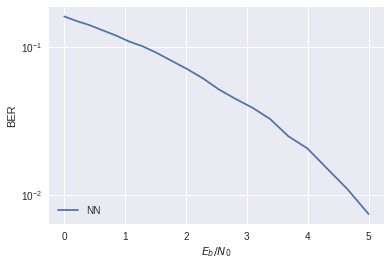

In [15]:
legend = []

plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), nb_errors/nb_bits)
legend.append('NN') 


plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')    
plt.grid(True)
plt.show()

(20,)


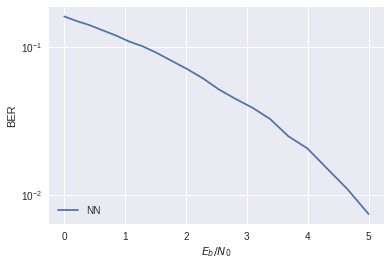

In [16]:
legend = []

plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), nb_errors/nb_bits)
legend.append('NN') 

print(np.shape(nb_errors))


plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')    
plt.grid(True)
plt.show()